# <p style="font-family:newtimeroman;font-size:150%;text-align:center;">Emotions Analysis </p>

## About the dataset
**INTRODUCTION**
- Welcome to the "Emotions" dataset – a collection of English Twitter messages meticulously annotated with six fundamental emotions: anger, fear, joy, love, sadness, and surprise. This dataset serves as a valuable resource for understanding and analyzing the diverse spectrum of emotions expressed in short-form text on social media.

**DATASET**

- Each entry in this dataset consists of a text segment representing a Twitter message and a corresponding label indicating the predominant emotion conveyed. The emotions are classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5). Whether you're interested in sentiment analysis, emotion classification, or text mining, this dataset provides a rich foundation for exploring the nuanced emotional landscape within the realm of social media.

**KEY FEATURES**

- text: A string feature representing the content of the Twitter message.
- label: A classification label indicating the primary emotion, with values ranging from 0 to 5.



## Importing Libraries

In [1]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter


from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

2024-03-27 04:07:55.751933: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 04:07:55.752102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 04:07:55.943914: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load the dataset

In [4]:
path = 'text.csv'
df = pd.read_csv(path)
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


### Checking for columns name, data types, missing values and duplicates

In [5]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['Missing#'] = df.isna().sum()
    summary_df['Duplicates'] = df.duplicated().sum()
    summary_df['Unique'] = df.nunique().values
    summary_df['Count'] = df.count().values
    return summary_df

summary(df).style.background_gradient(cmap='Blues')

,dtypes,Missing#,Duplicates,Unique,Count
Unnamed: 0,int64,0,0,416809,416809
text,object,0,0,393822,416809
label,int64,0,0,6,416809


In [6]:
# Drop the Index column
df.drop('Unnamed: 0',axis=1,inplace=True)

In [7]:
df.shape

(416809, 2)

In [8]:
# Lets create a new column 'Emotions' to store the labled emotions, this with become handy when performing visualization for the target
df['Emotions'] = df['label'] 
df['Emotions'] = df['Emotions'].replace(0,'Sadness')
df['Emotions'] = df['Emotions'].replace(1,'Joy')
df['Emotions'] = df['Emotions'].replace(2,'Love')
df['Emotions'] = df['Emotions'].replace(3,'Anger')
df['Emotions'] = df['Emotions'].replace(4,'Fear')
df['Emotions'] = df['Emotions'].replace(5,'Surprise')

In [9]:
df.head()

,text,label,Emotions
0,i just feel really helpless and heavy hearted,4,Fear
1,ive enjoyed being able to slouch about relax a...,0,Sadness
2,i gave up my internship with the dmrg and am f...,4,Fear
3,i dont know i feel so lost,0,Sadness
4,i am a kindergarten teacher and i am thoroughl...,4,Fear


In [10]:
# Create a new column "Text_len" that contain the lenght of each entry
df['Text_len'] = df['text'].apply(lambda x: len(x.split(' ')))
df.head()

,text,label,Emotions,Text_len
0,i just feel really helpless and heavy hearted,4,Fear,8
1,ive enjoyed being able to slouch about relax a...,0,Sadness,45
2,i gave up my internship with the dmrg and am f...,4,Fear,12
3,i dont know i feel so lost,0,Sadness,7
4,i am a kindergarten teacher and i am thoroughl...,4,Fear,42


In [11]:
# Check the maximum and minmun lenght of the enteries
print( "Maximuum lenght:", max(df['Text_len']))
print("Mimum lenght:", min(df['Text_len']))

Maximuum lenght: 178
Mimum lenght: 1


## Distribution of the Target

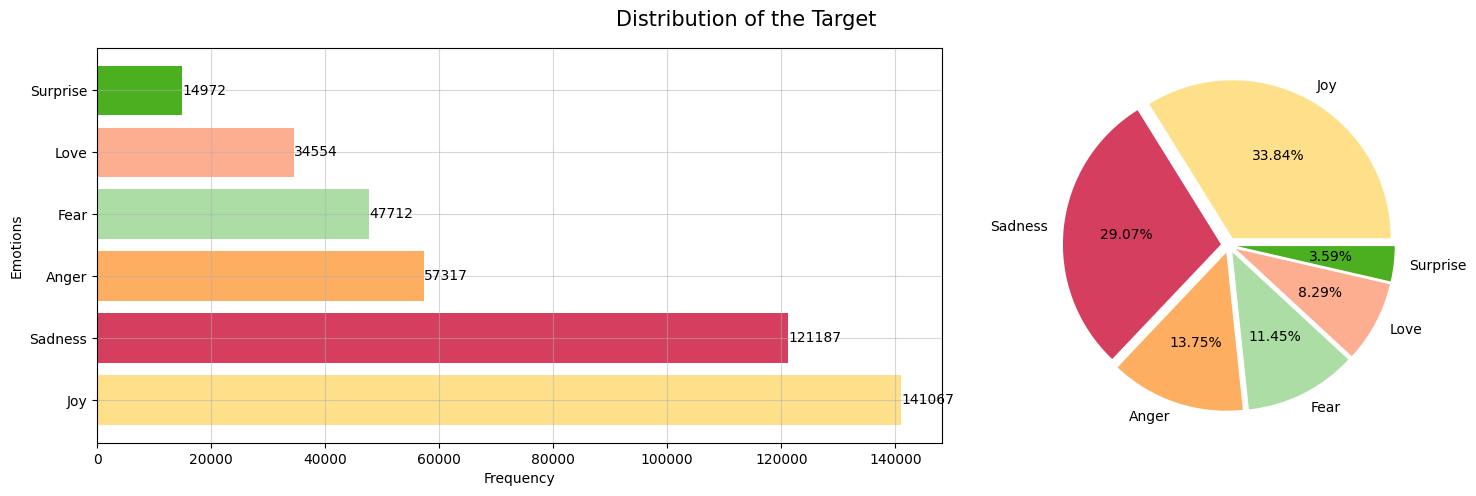

In [12]:
y = df['Emotions'].value_counts()
colors = [ "#fee08b" ,"#d53e5f","#fdae61", "#abdda4" ,"#fdae91" ,"#4CAF20" ]
figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[2,1]})


axes[0].barh(y=y.index, width=y.values, color=colors)
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Emotions')
axes[0].grid(alpha=0.5)
for index, values in enumerate(y):
    axes[0].text(values+1, index, str(values), va='center')

axes[1].pie(y.values, labels=y.index, autopct='%.2f%%', explode=([0.05]*len(y.index)), colors=colors)

    

figure.suptitle('Distribution of the Target', fontsize=15)
plt.tight_layout(pad=1)
plt.show()


## Data Preprocessing

### Data cleaning
* Removing url, emoji, html, punctuations, numbers and lowercasing

In [14]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
        '', 
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)
    
    return text

In [15]:
df['Text_clean'] = df['text'].apply(clean_text)
df.head()

,text,label,Emotions,Text_len,Text_clean
0,i just feel really helpless and heavy hearted,4,Fear,8,i just feel really helpless and heavy hearted
1,ive enjoyed being able to slouch about relax a...,0,Sadness,45,ive enjoyed being able to slouch about relax a...
2,i gave up my internship with the dmrg and am f...,4,Fear,12,i gave up my internship with the dmrg and am f...
3,i dont know i feel so lost,0,Sadness,7,i dont know i feel so lost
4,i am a kindergarten teacher and i am thoroughl...,4,Fear,42,i am a kindergarten teacher and i am thoroughl...


### Expanding abbreviations

In [16]:
def expand_abbreviations(text):
    abbreviations_dict = {
    "im": "i am",
    "ive": "i have"
}
    for abbreviation, expansion in abbreviations_dict.items():
        text = text.replace(abbreviation, expansion)
    return text

In [17]:
df['Text_clean'] = df['Text_clean'].apply(expand_abbreviations)

In [18]:
df['Text_clean']

0             i just feel really helpless and heavy hearted
1         i have enjoyed being able to slouch about rela...
2         i gave up my internship with the dmrg and am f...
3                                i dont know i feel so lost
4         i am a kindergarten teacher and i am thoroughl...
                                ...                        
416804    i feel like telling these horny devils to find...
416805    i began to realize that when i was feeling agi...
416806    i feel very curious be why previous early dawn...
416807    i feel that becuase of the tyranical nature of...
416808    i think that after i had spent some ti ame inv...
Name: Text_clean, Length: 416809, dtype: object

### Removing Stopwords

In [19]:
stop_words = stopwords.words('english')
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['Text_clean'] = df['Text_clean'].apply(remove_stopwords)
df.head()

,text,label,Emotions,Text_len,Text_clean
0,i just feel really helpless and heavy hearted,4,Fear,8,feel really helpless heavy hearted
1,ive enjoyed being able to slouch about relax a...,0,Sadness,45,enjoyed able slouch relax unwind frankly neede...
2,i gave up my internship with the dmrg and am f...,4,Fear,12,gave internship dmrg feeling distraught
3,i dont know i feel so lost,0,Sadness,7,dont know feel lost
4,i am a kindergarten teacher and i am thoroughl...,4,Fear,42,kindergarten teacher thoroughly weary job take...


### Stemming

In [20]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [21]:
df['Text_clean'] = df['Text_clean'].apply(stemm_text)
df.head()

,text,label,Emotions,Text_len,Text_clean
0,i just feel really helpless and heavy hearted,4,Fear,8,feel realli helpless heavi heart
1,ive enjoyed being able to slouch about relax a...,0,Sadness,45,enjoy abl slouch relax unwind frank need last ...
2,i gave up my internship with the dmrg and am f...,4,Fear,12,gave internship dmrg feel distraught
3,i dont know i feel so lost,0,Sadness,7,dont know feel lost
4,i am a kindergarten teacher and i am thoroughl...,4,Fear,42,kindergarten teacher thorough weari job taken ...


### Data Visualization

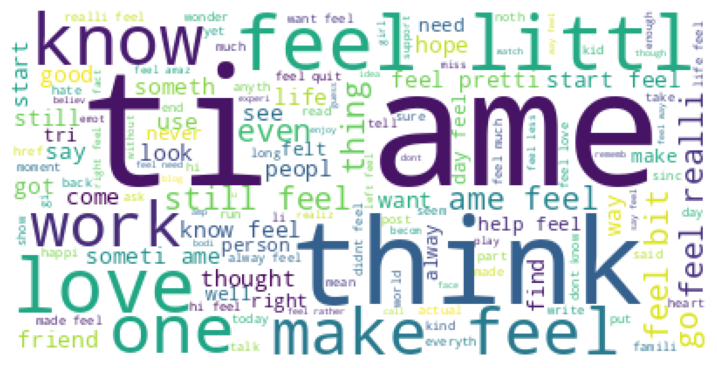

In [ ]:
all_text = " ".join(df['Text_clean'])
wc = WordCloud(background_color='white').generate(all_text)

plt.figure(figsize = (9,6))
plt.imshow(wc)
plt.axis('off')
plt.show()

### Train-Test Split

In [29]:
SEED = 42
from sklearn.model_selection import train_test_split

X = df['Text_clean']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = SEED, 
                                                    stratify = y)

X_train.shape, X_test.shape

((291766,), (125043,))

### Tokenization

In [30]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [25]:
# Max Len in X_train_sequences
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 48


In [26]:
# Perform padding on X_train and X_test sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post',)
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

# Print the padded sequences for X_train and X_test
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)

X_train_padded:
[[  313     1   166 ...     0     0     0]
 [   48   180    30 ...     0     0     0]
 [    1 19503   214 ...     0     0     0]
 ...
 [ 2601   331    18 ...     0     0     0]
 [   35     8     1 ...     0     0     0]
 [  169   116   198 ...     0     0     0]]

X_test_padded:
[[   1   52  586 ...    0    0    0]
 [   1  339 6646 ...    0    0    0]
 [   1   69  346 ...    0    0    0]
 ...
 [ 768 2169  170 ...    0    0    0]
 [   1   13  218 ...    0    0    0]
 [ 157  110 5517 ...    0    0    0]]


In [27]:
# Embedding Input Size / Vocabulary Size 
input_Size = np.max(X_train_padded) + 1
input_Size

43882

In [34]:
# Define the model
model = Sequential()

# Add embedding layer
model.add(Embedding(input_dim=input_Size, output_dim=50, input_shape=(48,)))

# Dropout
model.add(Dropout(0.5))

# Add Bidirectional LSTM layer
model.add(Bidirectional(GRU(120, return_sequences=True)))
model.add(Bidirectional(GRU(64, return_sequences=True)))

#Batch Normalization
model.add(BatchNormalization())

# Add Bidirectional GRU layer
model.add(Bidirectional(GRU(64)))

# Add output layer
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 48, 50)         │     2,194,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 48, 240)        │       123,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 48, 128)        │       117,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,511,226 (9.58 MB)

 Trainable params: 2,510,970 (9.58 MB)

 Non-trainable params: 256 (1.00 KB)

In [35]:
# Model Train 
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=1500, validation_data=(X_test_padded, y_test))

Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 687s 3s/step - accuracy: 0.6303 - loss: 0.9581 - val_accuracy: 0.8678 - val_loss: 0.7904
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 680s 3s/step - accuracy: 0.9151 - loss: 0.1886 - val_accuracy: 0.9114 - val_loss: 0.2067
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 687s 4s/step - accuracy: 0.9222 - loss: 0.1556 - val_accuracy: 0.9195 - val_loss: 0.1526
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 732s 3s/step - accuracy: 0.9260 - loss: 0.1428 - val_accuracy: 0.9194 - val_loss: 0.1465
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 681s 3s/step - accuracy: 0.9286 - loss: 0.1358 - val_accuracy: 0.9199 - val_loss: 0.1445


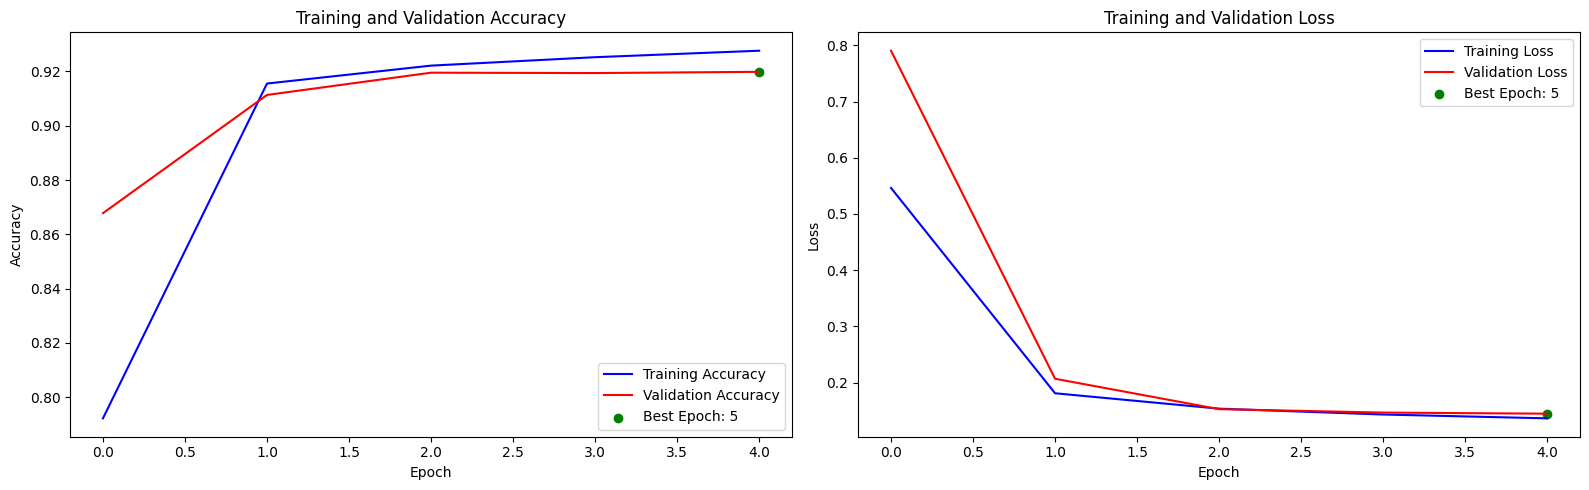

In [36]:
# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()


# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [37]:
# Evaluate Test Data 
model.evaluate(X_test_padded, y_test)

3908/3908 ━━━━━━━━━━━━━━━━━━━━ 167s 43ms/step - accuracy: 0.9200 - loss: 0.1443


[0.14456786215305328, 0.9198675751686096]

In [38]:
# Predictions On Test For Confustion Matrix 
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

3908/3908 ━━━━━━━━━━━━━━━━━━━━ 159s 40ms/step


<Axes: >

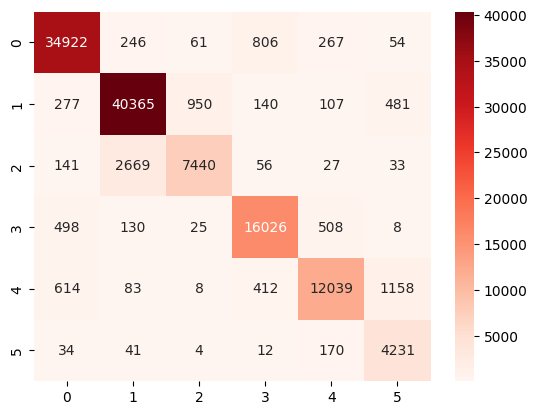

In [39]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')